# Notebook layout

'Run All' functionality is enabled.

The notebook contains the following sections that refer to the Modelling report layout for Group 13:
- 1.4.2 Time-series K-means Analysis, included in
    - 2.1) K Means - Timeseries

Note that the following sections are also included, however, the results of the analysis were deemed unfavourable for reporting purposes:
- 1) Visualisation of feature engineered dataset
- 2.2) K Shape
- 2.3) Logistic Regression
- 2.4) Linear Regression
- 2.5) K-means (standard)

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from functions import *
import winsound

C:\Python39\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Modelling

## 1) Visualisation of feature engineered dataset

### 1.1) Load data

In [2]:
leptoData = read_from_drive('https://drive.google.com/file/d/1GvzuS_mQkL7bBGu8jRn1IOehLcGX__zf/view?usp=sharing')
leptoData.head()

,Unnamed: 0,Id,Timeframe,Year,Lepto_Y_N,% Infestation,rainfalldiff,rainfall,rainfallavg,temperature_maxdiff,temperature_max,temperature_maxavg,temperature_mindiff,temperature_min,temperature_minavg,temperature_diffdiff,temperature_diff,temperature_diffavg
0,0,1,1,2017,Yes,72.0,-33.291304,151.5,184.791304,2.226002,29.335484,27.109482,1.785191,18.03871,16.253519,0.440811,11.296774,10.855963
1,1,2,1,2017,Yes,92.0,-62.415942,219.5,281.915942,0.652248,28.432258,27.780010,1.754252,20.10000,18.345748,-1.102004,8.332258,9.434262
2,2,3,1,2017,Yes,98.0,48.133333,301.5,253.366667,0.563832,28.432258,27.868426,2.227761,20.10000,17.872239,-1.663930,8.332258,9.996188
3,3,4,1,2017,Yes,100.0,16.333333,249.0,232.666667,0.563832,28.432258,27.868426,2.227761,20.10000,17.872239,-1.663930,8.332258,9.996188
4,4,5,1,2017,Yes,100.0,-28.066667,175.5,203.566667,-0.584506,28.432258,29.016764,2.092082,20.10000,18.007918,-2.676588,8.332258,11.008847


In [3]:
sirexData = read_from_drive('https://drive.google.com/file/d/1nM4cA8AReB7OJaZUfl04tdSioDnyuKpZ/view?usp=sharing')
sirexData["Sirex_Presence"] = np.where(sirexData["Sirex_Presence"] == "Sirex", 'Yes', 'No')
sirexData.head()

,Unnamed: 0,Id,Timeframe,Year,Sirex_Presence,rainfalldiff,rainfall,rainfallavg,temperature_maxdiff,temperature_max,temperature_maxavg,temperature_mindiff,temperature_min,temperature_minavg,temperature_diffdiff,temperature_diff,temperature_diffavg
0,0,392,1,2012,No,-64.017647,189.9,253.917647,2.981476,30.054839,27.073363,2.164076,20.309677,18.145601,0.817400,9.745161,8.927761
1,1,391,1,2012,No,-64.017647,189.9,253.917647,2.981476,30.054839,27.073363,2.164076,20.309677,18.145601,0.817400,9.745161,8.927761
2,2,390,1,2012,No,-67.923188,189.9,257.823188,2.981476,30.054839,27.073363,2.164076,20.309677,18.145601,0.817400,9.745161,8.927761
3,3,389,1,2012,No,166.217391,295.2,128.982609,2.851955,30.054839,27.202884,2.847556,20.309677,17.462121,0.004399,9.745161,9.740762
4,4,388,1,2012,No,71.920588,314.0,242.079412,1.874780,30.054839,28.180059,1.750440,20.309677,18.559238,0.124340,9.745161,9.620821


### 1.2) Normalize

In [4]:
leptoDataLeft, leptoDataBase = leptoData[['Timeframe','Year','Lepto_Y_N','% Infestation']], leptoData[['rainfalldiff','temperature_maxdiff','temperature_mindiff','temperature_diffdiff']]
leptoDataNorm = leptoDataLeft.join(((leptoDataBase-leptoDataBase.mean())/leptoDataBase.std()))

sirexDataLeft, sirexDataBase = sirexData[['Timeframe','Year','Sirex_Presence']], sirexData[['rainfalldiff','temperature_maxdiff','temperature_mindiff','temperature_diffdiff']]
sirexDataNorm = sirexDataLeft.join(((sirexDataBase-sirexDataBase.mean())/sirexDataBase.std()))

### 1.3) Visualise

#### 1.3.1) Graphing function 1

In [5]:
def getPlot(pestData,binaryCol, pesName, highlight, xminCol,xmaxCol):
    pestYav = pestData[pestData[binaryCol] == 'Yes'].groupby(['Timeframe']).mean().reset_index()
    pestNav = pestData[pestData[binaryCol] == 'No'].groupby(['Timeframe']).mean().reset_index()  

    yYRain, yNRain =pestYav['rainfalldiff'], pestNav['rainfalldiff']
    yYTmax, yNTmax =pestYav['temperature_maxdiff'], pestNav['temperature_maxdiff']
    yYTmin, yNTmin =pestYav['temperature_mindiff'], pestNav['temperature_mindiff']
    yYTdiff, yNTdiff =pestYav['temperature_diffdiff'], pestNav['temperature_diffdiff']
    xY,xN = pestYav['Timeframe'],pestNav['Timeframe']

    fig, (ax1, ax3, ax4) = plt.subplots(3, 1, sharex=True,figsize=(8, 10))
    plots = [ax1, ax3, ax4]
    yYplots, yNplots = [yYRain,yYTmax,yYTmin], [yNRain,yNTmax,yNTmin]
    colours = ['black','coral','limegreen']
    ylabels = ['Actual - average rainfall (mm)','Actual - average max temp ($^\circ$C)','Actual - average min temp ($^\circ$C)']

    if highlight:
        ax1.axvspan(xmin = xmaxCol[0], xmax = xminCol[0],  alpha=0.2, color='darkblue')
        ax3.axvspan(xmin = xmaxCol[1], xmax = xminCol[1], alpha=0.2, color='coral')
        ax4.axvspan(xmin = xmaxCol[2], xmax = xminCol[2], alpha=0.2, color='c')         

    for i in range(0,len(plots)):
        plots[i].xaxis.grid(True, which='minor')
        plots[i].axvspan(37, 49, alpha=0.3, color='black',label = 'Year of inspection')
        plots[i].plot(xY, yYplots[i], c = 'red', alpha = 1, label = pesName + ' Avg')
        plots[i].plot(xN, yNplots[i], c = 'limegreen', alpha = 1, label = 'No ' + pesName + ' Avg') 
        plots[i].fill_between(xY, yYplots[i], yNplots[i],color = 'black',alpha = 0.6)
        plots[i].legend(loc = 'lower right', prop={'size': 8})
        plots[i].set_ylabel(ylabels[i]) 
        plots[i].bar(xN,yYplots[i]-yNplots[i], color = 'black',alpha = 0.2, edgecolor='black',label = 'Difference (' + pesName + ' +ve) - (' + pesName + ' -ve)')
        plots[i].axvline(x=1,color = 'black')
        plots[i].axvline(x=13,color = 'black')
        plots[i].axvline(x=25,color = 'black')
        plots[i].axvline(x=37,color = 'black')

    ax4.set_xlabel('Months')
    ax4.set_xticks([1,13,25,37,49])
    ax4.set_xticks(range(1,49),minor=True)
    ax4.set_xticklabels(['Jan IY-3','Jan IY-2','Jan IY-1','Jan IY','Jan IY+1'], minor=False)
    return plt   

#### 1.3.2) Applied to pests

##### 1.3.2.1) Leptocybe

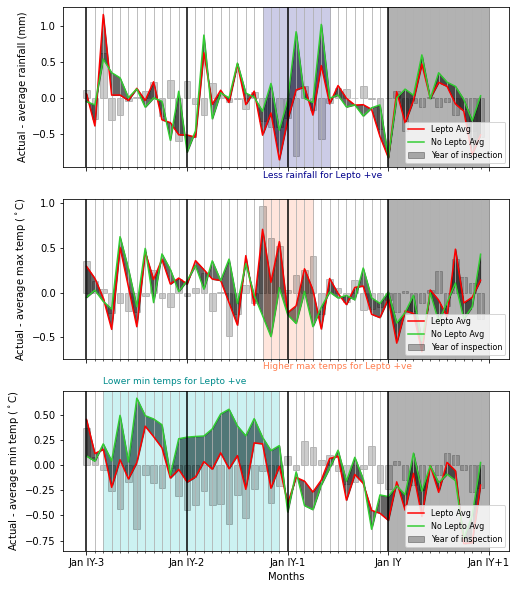

In [6]:
leptoPlot = getPlot(leptoDataNorm,'Lepto_Y_N','Lepto',True,[22,22,3],[30,28,24])
leptoPlot.text(22, 2.85, 'Less rainfall for Lepto +ve', fontsize=9, c = 'darkblue')
leptoPlot.text(22, 0.95, 'Higher max temps for Lepto +ve', fontsize=9, c='coral')
leptoPlot.text(3, 0.8, 'Lower min temps for Lepto +ve', fontsize=9, c='darkcyan')
leptoPlot.show()

##### 1.3.2.2) Sirex

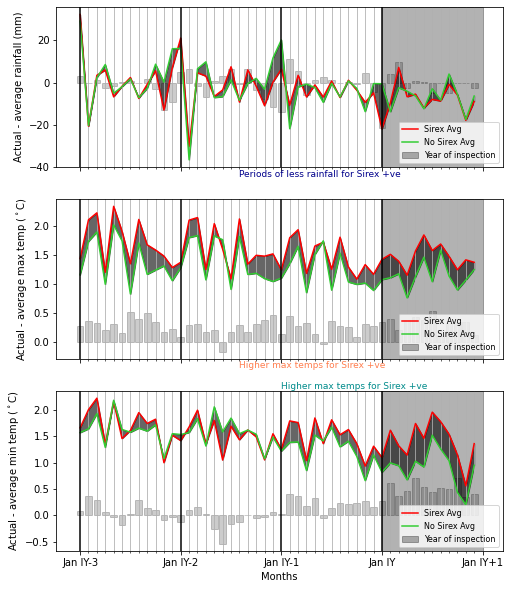

In [7]:
sirexPlot = getPlot(sirexData,'Sirex_Presence','Sirex',False,None,None)
sirexPlot.text(20, 6.4, 'Periods of less rainfall for Sirex +ve', fontsize=9, c = 'darkblue')
sirexPlot.text(20, 2.8, 'Higher max temps for Sirex +ve', fontsize=9, c='coral')
sirexPlot.text(25, 2.4, 'Higher max temps for Sirex +ve', fontsize=9, c='darkcyan')
sirexPlot.show()

#### 1.3.3) Graphing function 2

In [8]:
def getPlot2(pestData,binaryCol, pesName):
    pestYav = pestData[pestData[binaryCol] == 'Yes'].groupby(['Timeframe']).mean().reset_index()
    pestNav = pestData[pestData[binaryCol] == 'No'].groupby(['Timeframe']).mean().reset_index()

    yYRain, yNRain =pestYav['rainfalldiff'], pestNav['rainfalldiff']
    yYTmax, yNTmax =pestYav['temperature_maxdiff'], pestNav['temperature_maxdiff']
    yYTmin, yNTmin =pestYav['temperature_mindiff'], pestNav['temperature_mindiff']
    yYTdiff, yNTdiff =pestYav['temperature_diffdiff'], pestNav['temperature_diffdiff']
    xY,xN = pestYav['Timeframe'],pestNav['Timeframe']       

    x = np.arange(len(xN))  # the label locations
    width = 0.2 # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.axvspan(37, 49, alpha=0.1, color='black',label = 'Year of inspection')

    rects1 = ax.bar(x = x + 1, height = yYRain-yNRain, width = width, color = 'darkblue', linewidth = 0, label = 'Rainfall')
    rects3 = ax.bar(x = x + 1 + 1*width, height = yYTmax-yNTmax, width = width, color = 'coral', linewidth = 0, label = 'Tmax')
    rects4 = ax.bar(x = x + 1 + 2*width, height = yYTmin-yNTmin, width = width, color = 'c', linewidth = 0, label = 'Tmin')
    # rects2 = ax.bar(x = x + 1 + 3*width, height = yYTdiff-yNTdiff, width = width, color = 'purple', linewidth = 0, label = 'Tdiff')

    ax.set_ylabel(pesName +' (+ve inspection avg) - (-ve insepction avg)')
    ax.set_title('Months before and after start of inspection year')
    ax.axvline(x=1,color = 'black')
    ax.axvline(x=13,color = 'black')
    ax.axvline(x=25,color = 'black')

    ax.set_xlabel('Months')
    ax.set_xticks([1,13,25,37,49])
    ax.set_xticks(range(1,49),minor=True)
    ax.xaxis.grid(True, which='minor')
    ax.set_xticklabels(['Jan IY-3','Jan IY-2','Jan IY-1','Jan IY','Jan IY+1'], minor=False)

    ax.legend(loc = 'lower right')
    fig.tight_layout()
    return plt   

#### 1.3.4) Applied to pests

##### 1.3.4.1) Leptocybe

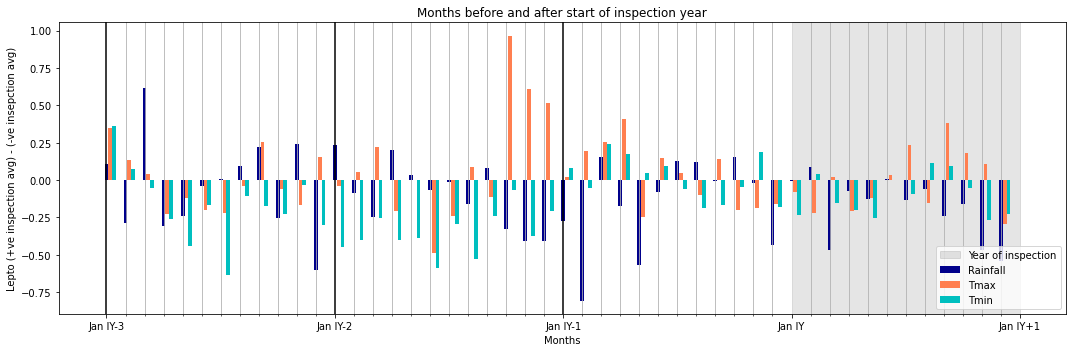

In [9]:
leptoPlot2 = getPlot2(leptoDataNorm,'Lepto_Y_N','Lepto')
leptoPlot2.show()

##### 1.3.4.2) Sirex

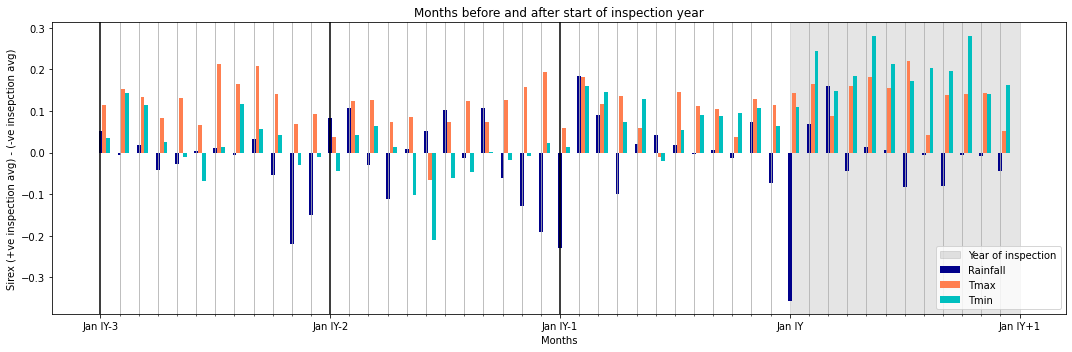

In [10]:
sirexPlot2 = getPlot2(sirexDataNorm,'Sirex_Presence','Sirex')
sirexPlot2.show()

## 2) Modelling

### 2.1) K Means - Timeseries

#### 2.1.1) Leptocybe

In [11]:
#Get files in format for timeseries modeling
currentFolder = 'C:/Users/gf2704928/Documents/_MIT (Desktop)/__DataFor808/Modeling/'

tempMinData = read_from_drive('https://drive.google.com/file/d/17dYeKlnsIV8B5wl2P5-max0PHIbxRIw_/view?usp=sharing')
tempMaxData = read_from_drive('https://drive.google.com/file/d/1OS3RnntKVq0F5aQBXlEnqxKvflEQpf2M/view?usp=sharing')
rainData = read_from_drive('https://drive.google.com/file/d/1sUGVOjJ0HU0uMc8kWnXjAKgz4cwVwfcg/view?usp=sharing')
tempDiffData = read_from_drive('https://drive.google.com/file/d/1FS4lO9HiUgxkHIsVD0oQF4pVnDLEd3Tn/view?usp=sharing')


tempMinData['Lepto_Y_N'] = tempMinData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
tempMaxData['Lepto_Y_N'] = tempMaxData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
rainData['Lepto_Y_N'] = rainData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
tempDiffData['Lepto_Y_N'] = tempDiffData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 

##### 2.1.1.1) Perturbation 1

In [12]:
startMonth = 1
endMonth = 48

tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX = tempMinData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempMaxData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),rainData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempDiffData.iloc[:,startMonth + 2:endMonth + 3].to_numpy()
X_train = np.concatenate((tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX)).reshape(4, *np.array(tempMinDataX).shape) #All
X_train = X_train.transpose(1,2,0)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train.shape

(252, 48, 4)

333.055 --> 166.707 --> 166.707 --> 
285.839 --> 149.777 --> 138.334 --> 135.244 --> 135.230 --> 135.230 --> 
227.837 --> 127.719 --> 119.729 --> 114.434 --> 114.218 --> 114.218 --> 
193.208 --> 108.997 --> 108.534 --> 108.350 --> 108.207 --> 108.187 --> 108.171 --> 108.171 --> 
180.054 --> 103.153 --> 102.198 --> 101.947 --> 101.786 --> 101.741 --> 101.741 --> 
164.757 --> 96.756 --> 95.318 --> 95.067 --> 94.906 --> 94.862 --> 94.862 --> 
157.646 --> 94.729 --> 93.017 --> 92.996 --> 92.996 --> 
154.269 --> 86.288 --> 84.617 --> 84.593 --> 84.593 --> 
138.727 --> 84.894 --> 83.452 --> 83.288 --> 83.288 --> 


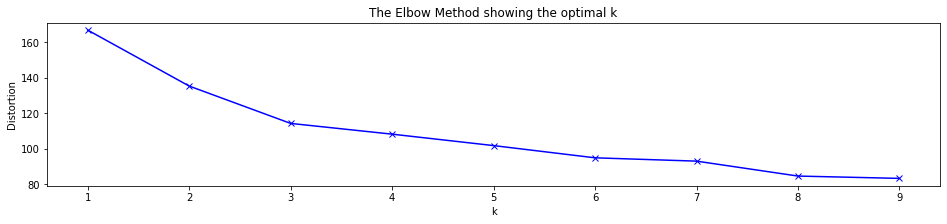

In [13]:
distortions = []
K = range(1, 10)
seed = 0
np.random.seed(seed)
for k in K:
    # Building and fitting the model
    kmeanModel = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=seed)
    kmeanModel.fit(X_train)  
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
winsound.Beep(440, 1000)

In [14]:
np.random.seed(0)
kk = 3
sz = X_train.shape[1]
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=kk, verbose=True, random_state=0)
y_pred = km.fit_predict(X_train)
trainDF = pd.DataFrame(np.column_stack([rainData[['Id','Lepto_Y_N']], y_pred]))
trainPivot = pd.pivot_table(trainDF,values=0,index=2,columns=1,aggfunc="count")
trainPivot["Perc"] = (trainPivot[1] / (trainPivot[1] + trainPivot[0]))*100

score = silhouette_score(X_train[:,:,0], km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)
print(trainPivot)
print('Standard deviation:')
print(trainPivot['Perc'].std())

Euclidean k-means
227.837 --> 127.719 --> 119.729 --> 114.434 --> 114.218 --> 114.218 --> 
Silhouette Score: 0.167
1    0   1       Perc
2                    
0   19  27  58.695652
1  101  33  24.626866
2   67   5   6.944444
Standard deviation:
26.30442844735461


##### 2.1.1.2) Pertubation 3

In [15]:
startMonth = 1
endMonth = 37

tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX = tempMinData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempMaxData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),rainData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempDiffData.iloc[:,startMonth + 2:endMonth + 3].to_numpy()

# X_train = np.concatenate((tempMinDataX,tempMaxDataX,rainDataX)).reshape(3, *np.array(tempMinDataX).shape) #All

X_train = np.concatenate((rainDataX)).reshape(1, *np.array(rainDataX).shape) #rainDataX GOOD    9
# X_train = np.concatenate((tempMinDataX)).reshape(1, *np.array(tempMinDataX).shape) #tempMinDataX 25, 4 47
# X_train = np.concatenate((tempMaxDataX)).reshape(1, *np.array(tempMaxDataX).shape) #tempMaxDataX    7
# X_train = np.concatenate((tempDiffDataX)).reshape(1, *np.array(tempDiffDataX).shape) #tempDiffDataX

# X_train = np.concatenate((tempDiffDataX,rainDataX)).reshape(2, *np.array(tempDiffDataX).shape) #Rain and temp diff GOOD
# X_train = np.concatenate((tempMaxDataX,rainDataX)).reshape(2, *np.array(tempMaxDataX).shape) #Rain and max temp GOOD
# X_train = np.concatenate((tempMinDataX,rainDataX)).reshape(2, *np.array(tempMinDataX).shape) #Rain and min temp
# X_train = np.concatenate((tempMaxDataX,tempMinDataX)).reshape(2, *np.array(tempMaxDataX).shape) #Max and min temp
# X_train = np.concatenate((tempMaxDataX,tempDiffDataX)).reshape(2, *np.array(tempMaxDataX).shape) #Max and temp diff
# X_train = np.concatenate((tempMinDataX,tempDiffDataX)).reshape(2, *np.array(tempMinDataX).shape) #Min and temp diff 39, 11, 21

# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train).transpose(1,2,0)
X_train = X_train.transpose(1,2,0)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

X_train.shape

(252, 37, 1)

59.370 --> 31.207 --> 31.207 --> 
48.841 --> 28.454 --> 28.238 --> 27.672 --> 26.951 --> 26.491 --> 26.200 --> 26.173 --> 26.171 --> 26.171 --> 
44.607 --> 24.726 --> 23.992 --> 23.327 --> 22.776 --> 22.626 --> 22.556 --> 22.523 --> 22.480 --> 22.471 --> 22.471 --> 
39.370 --> 23.690 --> 23.377 --> 23.177 --> 22.979 --> 22.106 --> 21.230 --> 20.937 --> 20.772 --> 20.638 --> 20.608 --> 20.608 --> 
36.575 --> 22.162 --> 21.616 --> 21.427 --> 21.076 --> 20.731 --> 20.603 --> 20.586 --> 20.538 --> 20.535 --> 20.535 --> 
34.353 --> 20.451 --> 19.803 --> 18.791 --> 18.412 --> 18.326 --> 18.292 --> 18.283 --> 18.276 --> 18.276 --> 
32.185 --> 19.618 --> 18.897 --> 17.854 --> 17.566 --> 17.483 --> 17.483 --> 
25.628 --> 16.543 --> 16.290 --> 16.189 --> 16.149 --> 16.149 --> 
24.053 --> 15.650 --> 15.384 --> 15.285 --> 15.225 --> 15.225 --> 


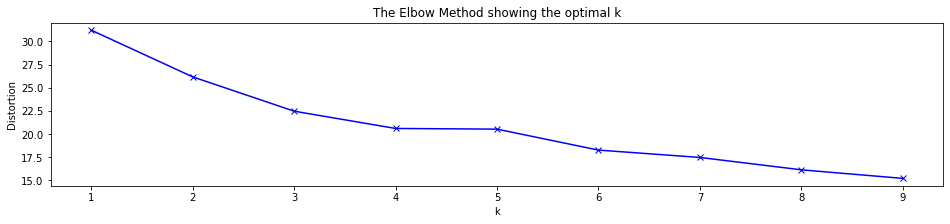

In [16]:
distortions = []
K = range(1, 10)
seed = 0
np.random.seed(seed)

for k in K:
    # Building and fitting the model
    kmeanModel = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=seed)
    kmeanModel.fit(X_train)    
 
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [17]:
seed = 0
np.random.seed(seed)
kk = 3
sz = X_train.shape[1]

km = TimeSeriesKMeans(n_clusters=kk, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
trainDF = pd.DataFrame(np.column_stack([rainData[['Id','Lepto_Y_N']], y_pred]))
trainPivot = pd.pivot_table(trainDF,values=0,index=2,columns=1,aggfunc="count")
trainPivot["Perc"] = (trainPivot[1] / (trainPivot[1] + trainPivot[0]))*100

score = silhouette_score(X_train[:,:,0], km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)
print(trainPivot)
print('Standard deviation:')
print(trainPivot['Perc'].std())

44.607 --> 24.726 --> 23.992 --> 23.327 --> 22.776 --> 22.626 --> 22.556 --> 22.523 --> 22.480 --> 22.471 --> 22.471 --> 
Silhouette Score: 0.206
1    0   1       Perc
2                    
0   22  29  56.862745
1  102  28  21.538462
2   63   8  11.267606
Standard deviation:
23.917260966280118


(11.0, 37.0)

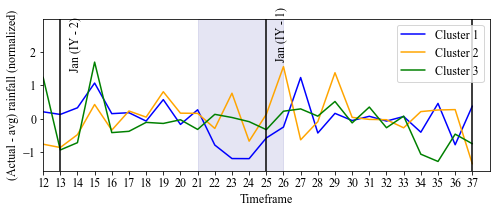

In [18]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
colors = ["blue","orange",'green',"black"]
plt.figure(figsize=(8,2.8))
plt.axvspan(xmin = 20, xmax = 25,  alpha=0.1, color='darkblue')
plt.axvspan(xmin = 1, xmax = 3,  alpha=0.1, color='darkblue')

for yi in range(kk):    
    plt.plot(km.cluster_centers_[yi].ravel(),solid_capstyle='round', label = 'Cluster '+str(yi+1), c = colors[yi])

plt.xticks(np.arange(len(km.cluster_centers_[yi].ravel())), np.arange(1, len(km.cluster_centers_[yi].ravel())+1))
plt.xlabel('Timeframe', size= 12)
plt.ylabel('(Actual - avg) rainfall (normalized)', size= 12)
plt.axvline(x=0,color = 'black')
plt.axvline(x=12,color = 'black')
plt.axvline(x=24,color = 'black')
plt.axvline(x=36,color = 'black')
plt.legend(loc = 'upper right', prop={'size': 12})
plt.text(12.5, 1.5, 'Jan (IY - 2)',rotation=90)
plt.text(24.5, 1.8, 'Jan (IY - 1)',rotation=90)
plt.xlim(11, 37)

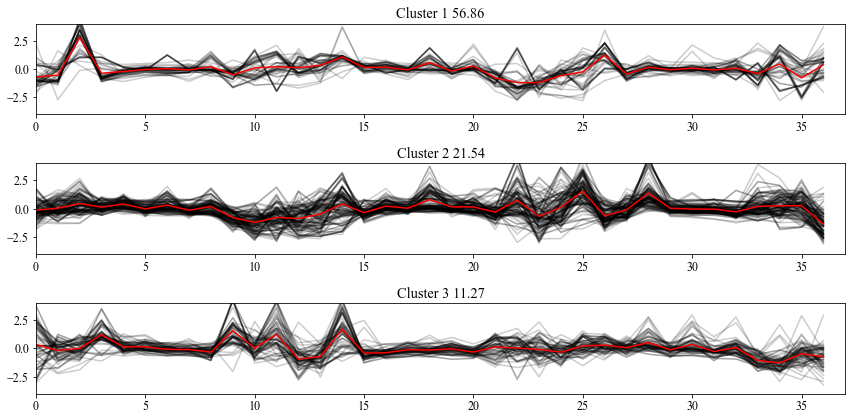

In [19]:
plt.figure(figsize=(12,kk*2))
for yi in range(kk):
    plt.subplot(kk, 1, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d %.2f" % (yi +1,trainPivot['Perc'].iloc[yi]))
    

plt.tight_layout()
plt.show()

#### 2.1.2) Sirex

In [20]:
#Get files in format for timeseries modeling
tempMinData = read_from_drive('https://drive.google.com/file/d/1koU_7by34xexIV6yet_e0hPwZA3DDDLV/view?usp=sharing')
tempMaxData = read_from_drive('https://drive.google.com/file/d/1LcHRDFgQoEsnUhIZlIoEIyMILfh8w2v5/view?usp=sharing')
rainData = read_from_drive('https://drive.google.com/file/d/1cZ9dVh8A_UImy9LGjET9cjBnY0sz5lAW/view?usp=sharing')
tempDiffData = read_from_drive('https://drive.google.com/file/d/1qZ9E-YZtX_JVqG9ejKTV592lfUrALGHo/view?usp=sharing')

tempMinData['Sirex_Presence'] = tempMinData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 
tempMaxData['Sirex_Presence'] = tempMaxData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 
rainData['Sirex_Presence'] = rainData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 
tempDiffData['Sirex_Presence'] = tempDiffData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 

##### 2.1.2.1) Perturbation 1

In [21]:
startMonth = 1
endMonth = 48

tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX = tempMinData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempMaxData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),rainData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempDiffData.iloc[:,startMonth + 2:endMonth + 3].to_numpy()
X_train = np.concatenate((tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX)).reshape(4, *np.array(tempMinDataX).shape) #All
X_train = X_train.transpose(1,2,0)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train.shape

(3254, 48, 4)

379.318 --> 184.931 --> 184.931 --> 
320.739 --> 175.519 --> 175.332 --> 175.258 --> 175.215 --> 175.137 --> 175.082 --> 175.050 --> 174.999 --> 174.871 --> 174.624 --> 174.371 --> 173.972 --> 173.621 --> 173.524 --> 173.471 --> 173.431 --> 173.417 --> 173.409 --> 173.407 --> 173.407 --> 173.407 --> 
294.036 --> 166.495 --> 165.064 --> 164.785 --> 164.652 --> 164.512 --> 164.357 --> 164.280 --> 164.280 --> 164.280 --> 
275.829 --> 159.884 --> 158.311 --> 157.428 --> 156.941 --> 156.530 --> 156.059 --> 155.884 --> 155.859 --> 155.828 --> 155.802 --> 155.775 --> 155.742 --> 155.728 --> 155.716 --> 155.712 --> 155.712 --> 
262.487 --> 154.374 --> 151.699 --> 150.534 --> 150.188 --> 149.992 --> 149.284 --> 149.136 --> 149.115 --> 149.080 --> 149.063 --> 149.011 --> 148.839 --> 148.760 --> 148.518 --> 148.449 --> 148.424 --> 148.365 --> 148.288 --> 148.164 --> 148.038 --> 147.930 --> 147.894 --> 147.890 --> 147.887 --> 147.883 --> 147.882 --> 147.881 --> 147.881 --> 147.873 --> 147.859 --> 

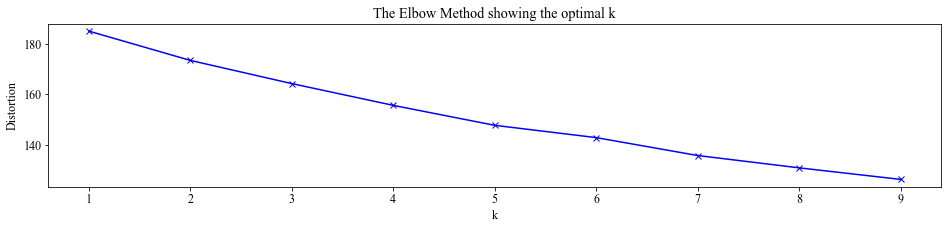

In [22]:
distortions = []
K = range(1, 10)
seed = 0
np.random.seed(seed)
for k in K:
    # Building and fitting the model
    kmeanModel = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=seed)
    kmeanModel.fit(X_train)  
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
winsound.Beep(440, 1000)

In [23]:
np.random.seed(0)
kk = 3
sz = X_train.shape[1]
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=kk, verbose=True, random_state=0)
y_pred = km.fit_predict(X_train)
trainDF = pd.DataFrame(np.column_stack([rainData[['Id','Sirex_Presence']], y_pred]))
trainPivot = pd.pivot_table(trainDF,values=0,index=2,columns=1,aggfunc="count")
trainPivot["Perc"] = (trainPivot[1] / (trainPivot[1] + trainPivot[0]))*100

score = silhouette_score(X_train[:,:,0], km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)
print(trainPivot)
print('Standard deviation:')
print(trainPivot['Perc'].std())

Euclidean k-means
294.036 --> 166.495 --> 165.064 --> 164.785 --> 164.652 --> 164.512 --> 164.357 --> 164.280 --> 164.280 --> 164.280 --> 
Silhouette Score: 0.104
1    0    1       Perc
2                     
0  818  351  30.025663
1  825  278  25.203989
2  771  211  21.486762
Standard deviation:
4.281338434960295


##### 2.2.1.2) Pertubation 3

In [24]:
startMonth = 1
endMonth = 37

tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX = tempMinData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempMaxData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),rainData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempDiffData.iloc[:,startMonth + 2:endMonth + 3].to_numpy()

# X_train = np.concatenate((tempMinDataX,tempMaxDataX,rainDataX)).reshape(3, *np.array(tempMinDataX).shape) #All

X_train = np.concatenate((rainDataX)).reshape(1, *np.array(rainDataX).shape) #rainDataX GOOD    9
# X_train = np.concatenate((tempMinDataX)).reshape(1, *np.array(tempMinDataX).shape) #tempMinDataX 25, 4 47
# X_train = np.concatenate((tempMaxDataX)).reshape(1, *np.array(tempMaxDataX).shape) #tempMaxDataX    7
# X_train = np.concatenate((tempDiffDataX)).reshape(1, *np.array(tempDiffDataX).shape) #tempDiffDataX

# X_train = np.concatenate((tempDiffDataX,rainDataX)).reshape(2, *np.array(tempDiffDataX).shape) #Rain and temp diff GOOD
# X_train = np.concatenate((tempMaxDataX,rainDataX)).reshape(2, *np.array(tempMaxDataX).shape) #Rain and max temp GOOD
# X_train = np.concatenate((tempMinDataX,rainDataX)).reshape(2, *np.array(tempMinDataX).shape) #Rain and min temp
# X_train = np.concatenate((tempMaxDataX,tempMinDataX)).reshape(2, *np.array(tempMaxDataX).shape) #Max and min temp
# X_train = np.concatenate((tempMaxDataX,tempDiffDataX)).reshape(2, *np.array(tempMaxDataX).shape) #Max and temp diff
# X_train = np.concatenate((tempMinDataX,tempDiffDataX)).reshape(2, *np.array(tempMinDataX).shape) #Min and temp diff 39, 11, 21

# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train).transpose(1,2,0)
X_train = X_train.transpose(1,2,0)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

X_train.shape

(3254, 37, 1)

70.455 --> 35.858 --> 35.858 --> 
60.784 --> 33.352 --> 32.741 --> 32.648 --> 32.608 --> 32.585 --> 32.573 --> 32.569 --> 32.564 --> 32.560 --> 32.560 --> 32.559 --> 32.558 --> 32.555 --> 32.551 --> 32.549 --> 32.548 --> 32.547 --> 32.547 --> 32.547 --> 32.547 --> 
55.784 --> 31.922 --> 31.564 --> 31.436 --> 31.358 --> 31.315 --> 31.276 --> 31.252 --> 31.239 --> 31.214 --> 31.204 --> 31.187 --> 31.174 --> 31.170 --> 31.166 --> 31.164 --> 31.161 --> 31.146 --> 31.104 --> 31.048 --> 31.007 --> 30.991 --> 30.947 --> 30.915 --> 30.904 --> 30.886 --> 30.873 --> 30.867 --> 30.865 --> 30.858 --> 30.858 --> 30.858 --> 30.858 --> 30.858 --> 30.858 --> 30.857 --> 30.857 --> 
51.548 --> 30.953 --> 30.378 --> 30.194 --> 30.083 --> 30.006 --> 29.972 --> 29.948 --> 29.936 --> 29.923 --> 29.907 --> 29.881 --> 29.863 --> 29.858 --> 29.849 --> 29.817 --> 29.713 --> 29.656 --> 29.644 --> 29.634 --> 29.632 --> 29.629 --> 29.627 --> 29.626 --> 29.626 --> 29.626 --> 29.626 --> 29.625 --> 29.623 --> 29.619 

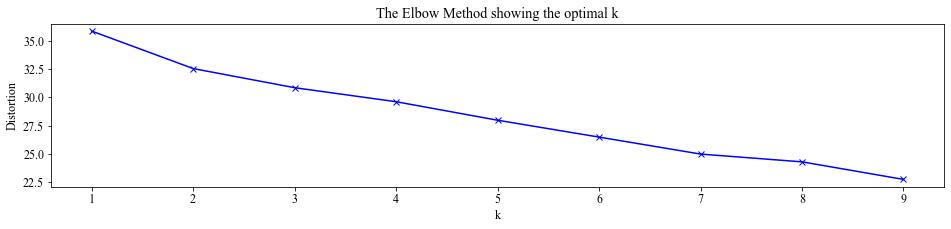

In [25]:
distortions = []
K = range(1, 10)
seed = 0
np.random.seed(seed)

for k in K:
    # Building and fitting the model
    kmeanModel = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=seed)
    kmeanModel.fit(X_train)    
 
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [26]:
seed = 0
np.random.seed(seed)
kk = 3
sz = X_train.shape[1]

km = TimeSeriesKMeans(n_clusters=kk, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
trainDF = pd.DataFrame(np.column_stack([rainData[['Id','Sirex_Presence']], y_pred]))
trainPivot = pd.pivot_table(trainDF,values=0,index=2,columns=1,aggfunc="count")
trainPivot["Perc"] = (trainPivot[1] / (trainPivot[1] + trainPivot[0]))*100

score = silhouette_score(X_train[:,:,0], km.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)
print(trainPivot)
print('Standard deviation:')
print(trainPivot['Perc'].std())

55.784 --> 31.922 --> 31.564 --> 31.436 --> 31.358 --> 31.315 --> 31.276 --> 31.252 --> 31.239 --> 31.214 --> 31.204 --> 31.187 --> 31.174 --> 31.170 --> 31.166 --> 31.164 --> 31.161 --> 31.146 --> 31.104 --> 31.048 --> 31.007 --> 30.991 --> 30.947 --> 30.915 --> 30.904 --> 30.886 --> 30.873 --> 30.867 --> 30.865 --> 30.858 --> 30.858 --> 30.858 --> 30.858 --> 30.858 --> 30.858 --> 30.857 --> 30.857 --> 
Silhouette Score: 0.082
1     0    1       Perc
2                      
0   607  177  22.576531
1  1184  413  25.860989
2   623  250  28.636884
Standard deviation:
3.0337311714221373


### 2.2) K Shape

#### 2.2.1) Lepto

In [27]:
#Get files in format for timeseries modeling

tempMinData = read_from_drive('https://drive.google.com/file/d/17dYeKlnsIV8B5wl2P5-max0PHIbxRIw_/view?usp=sharing')
tempMaxData = read_from_drive('https://drive.google.com/file/d/1OS3RnntKVq0F5aQBXlEnqxKvflEQpf2M/view?usp=sharing')
rainData = read_from_drive('https://drive.google.com/file/d/1sUGVOjJ0HU0uMc8kWnXjAKgz4cwVwfcg/view?usp=sharing')
tempDiffData = read_from_drive('https://drive.google.com/file/d/1FS4lO9HiUgxkHIsVD0oQF4pVnDLEd3Tn/view?usp=sharing')

tempMinData['Lepto_Y_N'] = tempMinData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
tempMaxData['Lepto_Y_N'] = tempMaxData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
rainData['Lepto_Y_N'] = rainData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
tempDiffData['Lepto_Y_N'] = tempDiffData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 

In [28]:
startMonth = 1
endMonth = 48

tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX = tempMinData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempMaxData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),rainData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempDiffData.iloc[:,startMonth + 2:endMonth + 3].to_numpy()
X_train = np.concatenate((tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX)).reshape(4, *np.array(tempMinDataX).shape) #All
X_train = X_train.transpose(1,2,0)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train.shape

(252, 48, 4)

In [29]:
# kShape clustering
kk = 3
seed = 0
np.random.seed(seed)
ks = KShape(n_clusters=kk, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

trainDF = pd.DataFrame(np.column_stack([rainData[['Id','Lepto_Y_N']], y_pred]))

trainPivot = pd.pivot_table(trainDF,values=0,index=2,columns=1,aggfunc="count")
trainPivot["Perc"] = (trainPivot[1] / (trainPivot[1] + trainPivot[0]))*100
trainPivot


0.640 --> 0.631 --> 0.623 --> 0.624 --> 


1,0,1,Perc
2,,,
0,54,15,21.739130
1,70,23,24.731183
2,63,27,30.000000


#### 2.2.2) Sirex

In [30]:
#Get files in format for timeseries modeling
tempMinData = read_from_drive('https://drive.google.com/file/d/1koU_7by34xexIV6yet_e0hPwZA3DDDLV/view?usp=sharing')
tempMaxData = read_from_drive('https://drive.google.com/file/d/1LcHRDFgQoEsnUhIZlIoEIyMILfh8w2v5/view?usp=sharing')
rainData = read_from_drive('https://drive.google.com/file/d/1cZ9dVh8A_UImy9LGjET9cjBnY0sz5lAW/view?usp=sharing')
tempDiffData = read_from_drive('https://drive.google.com/file/d/1qZ9E-YZtX_JVqG9ejKTV592lfUrALGHo/view?usp=sharing')

tempMinData['Sirex_Presence'] = tempMinData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 
tempMaxData['Sirex_Presence'] = tempMaxData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 
rainData['Sirex_Presence'] = rainData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 
tempDiffData['Sirex_Presence'] = tempDiffData['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0}) 

In [31]:
startMonth = 1
endMonth = 48

tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX = tempMinData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempMaxData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),rainData.iloc[:,startMonth + 2:endMonth + 3].to_numpy(),tempDiffData.iloc[:,startMonth + 2:endMonth + 3].to_numpy()
X_train = np.concatenate((tempMinDataX,tempMaxDataX,rainDataX,tempDiffDataX)).reshape(4, *np.array(tempMinDataX).shape) #All
X_train = X_train.transpose(1,2,0)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train.shape

(3254, 48, 4)

In [32]:
# kShape clustering
kk = 3
seed = 0
np.random.seed(seed)
ks = KShape(n_clusters=kk, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

trainDF = pd.DataFrame(np.column_stack([rainData[['Id','Sirex_Presence']], y_pred]))

trainPivot = pd.pivot_table(trainDF,values=0,index=2,columns=1,aggfunc="count")
trainPivot["Perc"] = (trainPivot[1] / (trainPivot[1] + trainPivot[0]))*100
trainPivot

0.640 --> 0.628 --> 0.630 --> 


1,0,1,Perc
2,,,
0,863,293,25.346021
1,699,294,29.607251
2,852,253,22.895928


### 2.3) Logistic Regression

#### 2.3.1) Leptocybe

Training size: (9676, 2) Test size: (2420, 2)
accuracy_score: 0.7421487603305785
Intercept: [-1.06103837]
Coeff: [[-0.09087246  0.02495442]]
confusion_matrix:
[[1796    0]
 [ 624    0]]
True negative(TN): 1796
False positive(FP): 0
True positive(TP): 0
False negative(FN): 624
specificity: 1.0
sensitivity: 0.0
Optimization terminated successfully.
         Current function value: 0.569994
         Iterations 5
roc_auc_score for Logistic Regression:  0.5534556849980012


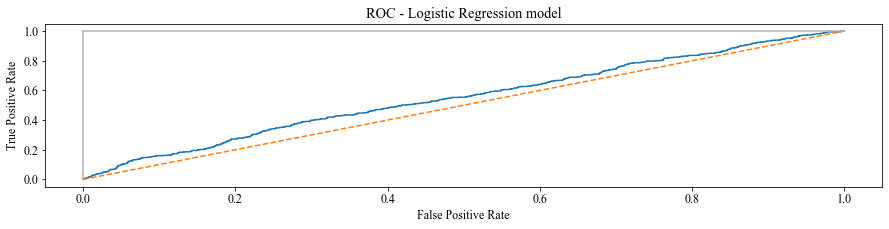

In [33]:
leptoData = read_from_drive('https://drive.google.com/file/d/1GvzuS_mQkL7bBGu8jRn1IOehLcGX__zf/view?usp=sharing')
leptoDataLeft, leptoDataBase = leptoData[['Id','Timeframe','Year','Lepto_Y_N']], leptoData[['rainfalldiff','temperature_maxdiff']]
leptoDataNorm = leptoDataLeft.join(((leptoDataBase-leptoDataBase.mean())/leptoDataBase.std()))
leptoDataNorm['Lepto_Y_N'] = leptoDataNorm['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 
leptoData = leptoDataNorm[['Id','Lepto_Y_N','rainfalldiff','temperature_maxdiff']]

Y = leptoData.iloc[:,1]
X = leptoData.iloc[:,2:]
i = int(0.8*len(Y))
X_train = X[:i]
X_test = X[i:]

Y_train = Y[:i].values.ravel()
Y_test = Y[i:].values.ravel()

print('Training size:',X_train.shape,'Test size:',X_test.shape)

LR = LogisticRegression(max_iter=5000, C=1e8)
LR.fit(X_train, Y_train)
predictions = LR.predict(X_test)
print("accuracy_score:",accuracy_score(Y_test, predictions))
print("Intercept:",LR.intercept_)
print("Coeff:",LR.coef_)

cm = confusion_matrix(Y_test, predictions)
print("confusion_matrix:")
print(cm)

TN = cm[0][0]
FP = cm[0][1]
TP = cm[1][1]
FN = cm[1][0]

print("True negative(TN):", TN)
print("False positive(FP):", FP)
print("True positive(TP):", TP)
print("False negative(FN):", FN)

specificity = TN/(TN + FP)
print("specificity:", specificity)
sensitivity = TP/(FN + TP)
print("sensitivity:", sensitivity)

logit_model=sm.MNLogit(Y_train,sm.add_constant(X_train))
logit_model
# result=logit_model.fit_regularized()
result=logit_model.fit()
stats1=result.summary()
# stats2=result.summary2()
# print(stats1)
y_score1 = LR.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_score1)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(Y_test, y_score1))

plt.subplots(1, figsize=(15,3))
plt.title('ROC - Logistic Regression model')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### 2.3.2) Sirex

Training size: (124953, 2) Test size: (31239, 2)
accuracy_score: 0.7419251576554947
Intercept: [-1.06031676]
Coeff: [[0.0010547  0.11289445]]
confusion_matrix:
[[23177     0]
 [ 8062     0]]
True negative(TN): 23177
False positive(FP): 0
True positive(TP): 0
False negative(FN): 8062
specificity: 1.0
sensitivity: 0.0
Optimization terminated successfully.
         Current function value: 0.569927
         Iterations 5
roc_auc_score for Logistic Regression:  0.537226298041154


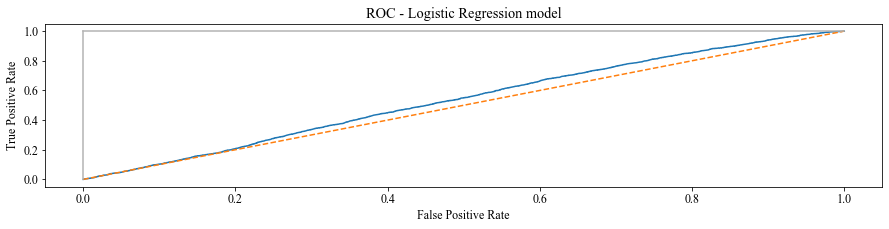

In [34]:
sirexData = read_from_drive('https://drive.google.com/file/d/1nM4cA8AReB7OJaZUfl04tdSioDnyuKpZ/view?usp=sharing')
sirexDataLeft, sirexDataBase = sirexData[['Id','Timeframe','Year','Sirex_Presence']], sirexData[['rainfalldiff','temperature_maxdiff']]
sirexDataNorm = sirexDataLeft.join(((sirexDataBase-sirexDataBase.mean())/sirexDataBase.std()))

sirexDataNorm['Sirex_Presence'] = sirexDataNorm['Sirex_Presence'].map({'Sirex': 1, 'No Sirex': 0})
sirexData = sirexDataNorm[['Id','Sirex_Presence','rainfalldiff','temperature_maxdiff']]

Y = sirexData.iloc[:,1]
X = sirexData.iloc[:,2:]
i = int(0.8*len(Y))
X_train = X[:i]
X_test = X[i:]

Y_train = Y[:i].values.ravel()
Y_test = Y[i:].values.ravel()

print('Training size:',X_train.shape,'Test size:',X_test.shape)

LR = LogisticRegression(max_iter=5000, C=1e8)
LR.fit(X_train, Y_train)
predictions = LR.predict(X_test)
print("accuracy_score:",accuracy_score(Y_test, predictions))
print("Intercept:",LR.intercept_)
print("Coeff:",LR.coef_)

cm = confusion_matrix(Y_test, predictions)
print("confusion_matrix:")
print(cm)

TN = cm[0][0]
FP = cm[0][1]
TP = cm[1][1]
FN = cm[1][0]

print("True negative(TN):", TN)
print("False positive(FP):", FP)
print("True positive(TP):", TP)
print("False negative(FN):", FN)

specificity = TN/(TN + FP)
print("specificity:", specificity)
sensitivity = TP/(FN + TP)
print("sensitivity:", sensitivity)

logit_model=sm.MNLogit(Y_train,sm.add_constant(X_train))
logit_model
# result=logit_model.fit_regularized()
result=logit_model.fit()
stats1=result.summary()
# stats2=result.summary2()
# print(stats1)
y_score1 = LR.predict_proba(X_test)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_score1)
print('roc_auc_score for Logistic Regression: ', roc_auc_score(Y_test, y_score1))

plt.subplots(1, figsize=(15,3))
plt.title('ROC - Logistic Regression model')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### 2.4) Linear Regression

#### 2.4.1) Leptocybe only

In [35]:
leptoData = read_from_drive('https://drive.google.com/file/d/1GvzuS_mQkL7bBGu8jRn1IOehLcGX__zf/view?usp=sharing')

leptoDataLeft, leptoDataBase = leptoData[['Id','Timeframe','Year','Lepto_Y_N','% Infestation']], leptoData[['rainfalldiff','temperature_maxdiff']]
leptoDataNorm = leptoDataLeft.join(((leptoDataBase-leptoDataBase.mean())/leptoDataBase.std()))

leptoData = leptoDataNorm[['Id','% Infestation','rainfalldiff','temperature_maxdiff']]


Y = leptoData.iloc[:,1]
X = leptoData.iloc[:,2:]
i = int(0.8*len(Y))
X_train = X[:i]
X_test = X[i:]

Y_train = Y[:i].values.ravel()
Y_test = Y[i:].values.ravel()

print('Training size:',X_train.shape,'Test size:',X_test.shape)

LinearR = LinearRegression()
LinearR.fit(X_train, Y_train)

print("Intercept:",LinearR.intercept_)
print("Coeff:",LinearR.coef_)
predicted_y = LinearR.predict(X_test)

from sklearn.metrics import mean_squared_error
print('The MSE is', mean_squared_error(Y_test, predicted_y))
print('Variance score: %.2f' % LinearR.score(X_test, Y_test))


sm_model=sm.OLS(Y_train,sm.add_constant(X_train))
sm_model
result=sm_model.fit()
stats1=result.summary()
print(stats1)


Training size: (9676, 2) Test size: (2420, 2)
Intercept: 17.16181581942736
Coeff: [-0.32912479  2.29714132]
The MSE is 1208.7099486293414
Variance score: 0.00
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     23.06
Date:                Sat, 30 Apr 2022   Prob (F-statistic):           1.02e-10
Time:                        19:17:13   Log-Likelihood:                -48090.
No. Observations:                9676   AIC:                         9.619e+04
Df Residuals:                    9673   BIC:                         9.621e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          

### 2.5) K-means (standard)

In [36]:
#Choose parameters
leptoData = read_from_drive('https://drive.google.com/file/d/1GvzuS_mQkL7bBGu8jRn1IOehLcGX__zf/view?usp=sharing')

leptoData = leptoData[(leptoData['Timeframe'] >=10) & (leptoData['Timeframe'] <=16)]


leptoDataLeft, leptoDataBase = leptoData[['Id','Timeframe','Year','Lepto_Y_N','% Infestation']], leptoData[['rainfalldiff','temperature_maxdiff']]
leptoDataNorm = leptoDataLeft.join(((leptoDataBase-leptoDataBase.mean())/leptoDataBase.std()))

leptoData = leptoDataNorm[['Id','Timeframe','Lepto_Y_N','rainfalldiff','temperature_maxdiff']]
leptoData['Lepto_Y_N'] = leptoData['Lepto_Y_N'].map({'Yes': 1, 'No': 0}) 

X = leptoData.iloc[:,3:]

print(X.columns)

kmeans = KMeans(3)
kmeans.fit(X)
identified_clusters = kmeans.fit_predict(X)
data_with_clusters = leptoData.copy()
data_with_clusters["Clusters"] = identified_clusters

Summary = pd.pivot_table(
    data_with_clusters,
    values="temperature_maxdiff",
    index="Clusters",
    columns="Lepto_Y_N",
    aggfunc="count",
)
Summary["Perc"] = Summary[1] / (Summary[1] + Summary[0])
Summary

Index(['rainfalldiff', 'temperature_maxdiff'], dtype='object')


C:\Users\gf2704928\AppData\Local\Temp\ipykernel_2260\1031537557.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leptoData['Lepto_Y_N'] = leptoData['Lepto_Y_N'].map({'Yes': 1, 'No': 0})


Lepto_Y_N,0,1,Perc
Clusters,,,
0,350,140,0.285714
1,468,167,0.262992
2,491,148,0.231612


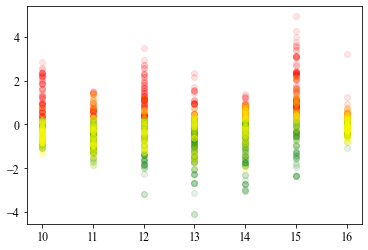

In [37]:
x0 = data_with_clusters["Timeframe"][data_with_clusters["Clusters"] == 0]
y0 = pd.to_numeric(data_with_clusters["rainfalldiff"][data_with_clusters["Clusters"] == 0])

x1 = data_with_clusters["Timeframe"][data_with_clusters["Clusters"] == 1]
y1 = pd.to_numeric(data_with_clusters["rainfalldiff"][data_with_clusters["Clusters"] == 1])

x2 = data_with_clusters["Timeframe"][data_with_clusters["Clusters"] == 2]
y2 = pd.to_numeric(data_with_clusters["rainfalldiff"][data_with_clusters["Clusters"] == 2])


plt.scatter(x0, y0, c="red", alpha=0.1)
plt.scatter(x1, y1, c="green", alpha=0.1)
plt.scatter(x2, y2, c="yellow", alpha=0.1)
plt.show()
